# Imports

In [2]:
# import wandb
# wandb.login()

# wandb.init(
#     project="ukrainian-sentiment",  # Name your project
#     name="roberta-ukrainian-sentiment",  # Optional run name
#     tags=["roberta", "ukrainian", "sentiment"],  # Optional tags for filtering
# )

In [70]:
!pip install seaborn --quiet

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from transformers import pipeline, RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.calibration import calibration_curve

from safetensors import safe_open
from safetensors.torch import load_file

In [2]:
# import matplotlib as mpl

# mpl.rcParams.update({
#     "font.size": 14,         # base font size
#     "axes.titlesize": 14,
#     "axes.labelsize": 14,
#     "xtick.labelsize": 14,
#     "ytick.labelsize": 14,
#     "legend.fontsize": 14,
# })

# Data

In [2]:
df = pd.read_parquet('final_17042025.parquet')

In [3]:
df.shape

(12224, 18)

In [4]:
df.reset_index(inplace=True)

In [5]:
df

,index,response_id,document_id,user_id,annotator_sentiment,is_ck_annotation,response_timestamp,document_content,annotation_date,username,unique_document_id,language_wc,document_length,gpt_labels_v1,language_gpt,language_manual,language,stratification_label,df_set
0,0,1,1,277133851,neutral,1,2025-03-09T23:23:07.220881,⚡️Українська делегація відправилася на перемов...,2025-03-09,O,1_1,uk,67,neutral,Ukrainian,ukrainian,ua,neutral_ua,train
1,1,3,2,1065283664,neutral,1,2025-03-09T23:44:28.262307,"Вибухи на Одещині, попередньо — ППО.",2025-03-09,A,2_1,uk,36,negative,Ukrainian,ukrainian,ua,neutral_ua,validation
2,2,4,3,1065283664,negative,1,2025-03-09T23:45:00.503098,"А что делать тем ,кто лишился своего жилья ,по...",2025-03-09,A,3_1,ru,177,negative,Code-mixed,russian,ru,negative_ru,test
3,3,5,4,1065283664,negative,1,2025-03-09T23:46:33.265766,Тогда учись быстро бегать. Для меня вопрос сло...,2025-03-09,A,4_1,ru,103,negative,Code-mixed,russian,ru,negative_ru,train
4,4,6,5,1065283664,neutral,1,2025-03-09T23:46:38.993496,Добрий день,2025-03-09,A,5_1,uk,11,neutral,Ukrainian,russian,ua,neutral_ua,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12219,12219,13028,8948,467130971,negative,0,2025-04-04T08:02:37.362562,"Краще ""повинна бути зручнішою, ніж Uber чи Boo...",2025-04-04,D,8948_0,uk,51,positive,Code-mixed,ukrainian,ua,negative_ua,train
12220,12220,13029,2094,467130971,mixed,0,2025-04-04T08:03:35.792932,Увага! З деяких інтернет джерел шириться інфор...,2025-04-04,D,2094_0,uk,402,positive,Ukrainian,ukrainian,ua,mixed_ua,train
12221,12221,13030,5013,467130971,neutral,0,2025-04-04T08:03:42.008533,"Питання, цей сертифікат можна вже використовув...",2025-04-04,D,5013_0,uk,113,neutral,Ukrainian,ukrainian,ua,neutral_ua,train
12222,12222,13031,4572,467130971,negative,0,2025-04-04T08:03:48.251166,На Вугледарському напрямку загинув Рома Іванен...,2025-04-04,D,4572_0,uk,114,negative,Ukrainian,ukrainian,ua,negative_ua,train


In [6]:
splits_df = {}

for sett in df.df_set.unique():
    splits_df[sett] = df.loc[df['df_set'] == sett].copy()

In [7]:
train_df = splits_df['train']
val_df = splits_df['validation']
test_df = splits_df['test']

In [8]:
# train_df = train_df.loc[:, ['document_content', 'annotator_sentiment']]

# Model - UkrRoberta

In [8]:
num_labels=df.annotator_sentiment.nunique()

In [9]:
num_labels

4

In [10]:
# Load model with increased dropout
config = RobertaConfig.from_pretrained(
    "youscan/ukr-roberta-base",
    num_labels=num_labels,
    hidden_dropout_prob=0.2,    # Increase from default (typically 0.1)
    attention_probs_dropout_prob=0.2
)

In [11]:
model = RobertaForSequenceClassification.from_pretrained("youscan/ukr-roberta-base", num_labels=num_labels)
tokenizer = RobertaTokenizer.from_pretrained("youscan/ukr-roberta-base")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at youscan/ukr-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model - mBERT

In [12]:
num_labels=df.annotator_sentiment.nunique()

In [13]:
num_labels

4

In [14]:
config = BertConfig.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_labels,
    hidden_dropout_prob=0.2,    # Increase from default (typically 0.1)
    attention_probs_dropout_prob=0.2
)

In [15]:
model_bert = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", config=config)
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Dataloaders

In [16]:
MAX_LENGTH = 512

In [17]:
# Function to create data loaders
def create_data_loaders(train_dataset, val_dataset, test_dataset, test_dataset_ru, test_dataset_ua, test_dataset_mixed, batch_size=16):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    test_loader_ru = DataLoader(
        test_dataset_ru,
        batch_size=batch_size,
        shuffle=False
    )

    test_loader_ua = DataLoader(
        test_dataset_ua,
        batch_size=batch_size,
        shuffle=False
    )

    test_loader_mixed = DataLoader(
        test_dataset_mixed,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_loader, val_loader, test_loader, test_loader_ru, test_loader_ua, test_loader_mixed

In [18]:
class SentimentDataset(Dataset):
    def __init__(self, texts, df_ids, labels, tokenizer, max_length=512, strategy="truncate"):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.strategy = strategy
        self.df_ids = df_ids

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        df_id = self.df_ids[idx]
        

        # Different strategies for handling long texts
        if self.strategy == "truncate":
            # Simple truncation from the beginning
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )

        elif self.strategy == "head_tail":
            # Take first half tokens from beginning, second half from end
            tokens = self.tokenizer.tokenize(text)
            if len(tokens) > self.max_length - 2:  # Account for special tokens
                half_length = (self.max_length - 2) // 2
                tokens = tokens[:half_length] + tokens[-half_length:]

            encoding = self.tokenizer.encode_plus(
                self.tokenizer.convert_tokens_to_string(tokens),
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'df_ids': torch.tensor(df_id, dtype=torch.int32),
        }

In [19]:
# Function to process dataset with chosen strategy
def prepare_datasets(train_df, val_df, test_df, tokenizer, max_length=512, strategy="truncate"):
    # Encode the sentiment labels
    label_encoder = LabelEncoder()

    # Fit on the entire dataset to ensure all classes are included
    all_sentiments = pd.concat([
        train_df['annotator_sentiment'],
        val_df['annotator_sentiment'],
        test_df['annotator_sentiment']
    ])
    label_encoder.fit(all_sentiments)

    # Transform the labels
    train_labels = label_encoder.transform(train_df['annotator_sentiment'])
    val_labels = label_encoder.transform(val_df['annotator_sentiment'])
    test_labels = label_encoder.transform(test_df['annotator_sentiment'])
    test_labels_ru = label_encoder.transform(test_df.loc[test_df.language=='ru', 'annotator_sentiment'])
    test_labels_ua = label_encoder.transform(test_df.loc[test_df.language=='ua', 'annotator_sentiment'])
    test_labels_mixed = label_encoder.transform(test_df.loc[test_df.language=='mixed', 'annotator_sentiment'])

    # Create datasets
    train_dataset = SentimentDataset(
        train_df['document_content'].values,
        train_df['index'].values,
        train_labels,
        tokenizer,
        max_length,
        strategy
    )

    val_dataset = SentimentDataset(
        val_df['document_content'].values,
        val_df['index'].values,
        val_labels,
        tokenizer,
        max_length,
        strategy
    )

    test_dataset = SentimentDataset(
        test_df['document_content'].values,
        test_df['index'].values,
        test_labels,
        tokenizer,
        max_length,
        strategy
    )

    test_dataset_ru = SentimentDataset(
        test_df.loc[test_df.language=='ru', 'document_content'].values,
        test_df.loc[test_df.language=='ru', 'index'].values,
        test_labels_ru,
        tokenizer,
        max_length,
        strategy
    )

    test_dataset_ua = SentimentDataset(
        test_df.loc[test_df.language=='ua', 'document_content'].values,
        test_df.loc[test_df.language=='ua', 'index'].values,
        test_labels_ua,
        tokenizer,
        max_length,
        strategy
    )

    test_dataset_mixed = SentimentDataset(
        test_df.loc[test_df.language=='mixed', 'document_content'].values,
        test_df.loc[test_df.language=='mixed', 'index'].values,
        test_labels_mixed,
        tokenizer,
        max_length,
        strategy
    )
    

    return train_dataset, val_dataset, test_dataset, test_dataset_ru, test_dataset_ua, test_dataset_mixed, label_encoder

In [20]:
train_dataset, val_dataset, test_dataset, test_dataset_ru, test_dataset_ua, test_dataset_mixed, label_encoder = prepare_datasets(
    train_df, val_df, test_df, tokenizer, MAX_LENGTH, strategy="truncate" #head_tail
)

train_loader, val_loader, test_loader, test_loader_ru, test_loader_ua, test_loader_mixed = create_data_loaders(
    train_dataset, val_dataset, test_dataset, test_dataset_ru, test_dataset_ua, test_dataset_mixed, batch_size=16
)

In [21]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Read models state 

In [22]:
model_path = "./best_models/ukrroberta_best.safetensors"

In [23]:
state_dict = load_file(model_path)

In [24]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [26]:
model_path = "./best_models/mbert_best.safetensors"

In [27]:
state_dict = load_file(model_path)

In [28]:
model_bert.load_state_dict(state_dict)

<All keys matched successfully>

In [29]:
model_bert.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [31]:
{
    'LABEL_0': 'mixed',
    'LABEL_1': 'negative',
    'LABEL_2': 'neutral',
    'LABEL_3': 'positive',
}

{'LABEL_0': 'mixed',
 'LABEL_1': 'negative',
 'LABEL_2': 'neutral',
 'LABEL_3': 'positive'}

In [30]:
def predict_sentiment(text, model, tokenizer):
    # Prepare the text input
    inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=512)
    
    # Move inputs to the same device as the model
    device = model.device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
    
    # Map the prediction to sentiment labels
    # Assuming the labels are: 0=negative, 1=neutral, 2=positive, 3=mixed (adjust as needed)
    sentiment_labels = ["mixed", "negative", "neutral", "positive"]
    predicted_sentiment = sentiment_labels[predictions.item()]
    
    return {
        'prediction': predictions.item(),
        'sentiment': predicted_sentiment,
        'scores': torch.nn.functional.softmax(logits, dim=1).tolist()[0]
    }

In [31]:
def evaluate_model(model, dataloader, batch_size=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    all_indeces = []
    all_probs = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            indeces = batch['df_ids'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_indeces.extend(indeces.cpu().numpy())
            all_probs.extend(probs)
            
    # Generate classification report
    sentiment_labels = ["mixed", "negative", "neutral", "positive"]
    report = classification_report(
        all_labels, 
        all_preds, 
        target_names=sentiment_labels,
        digits=4
    )
    
    return report, all_labels, all_preds, all_indeces, all_probs

# Examples

In [26]:
sample_text = "Це був чудовий день в Україні!"

In [27]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Це був чудовий день в Україні!
Predicted sentiment: positive
Confidence scores: [0.012194710783660412, 0.003013025736436248, 0.006361453328281641, 0.9784308075904846]


In [28]:
sample_text = "Страви були чудові! Але курєр був дууууже повільним і спізнився на 10 хвилин"

In [29]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Страви були чудові! Але курєр був дууууже повільним і спізнився на 10 хвилин
Predicted sentiment: positive
Confidence scores: [0.2520087957382202, 0.03747483715415001, 0.014695629477500916, 0.6958208084106445]


In [68]:
sample_text = "Страви були чудові! Але курєр був дууууже повільним і спізнився, був грубив і засмутив всю мою родину"

In [69]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Страви були чудові! Але курєр був дууууже повільним і спізнився, був грубив і засмутив всю мою родину
Predicted sentiment: positive
Confidence scores: [0.3225031793117523, 0.04648047313094139, 0.010628688149154186, 0.620387613773346]


In [71]:
sample_text = "Страви були непогані. Попри це, курєр був дууууже повільним і спізнився, був грубив і засмутив всю мою родину"

In [72]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Страви були непогані. Попри це, курєр був дууууже повільним і спізнився, був грубив і засмутив всю мою родину
Predicted sentiment: mixed
Confidence scores: [0.571321964263916, 0.09259159117937088, 0.02021961472928524, 0.3158668875694275]


In [30]:
sample_text = "Тріпі трапі тропі тропа"

In [31]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Тріпі трапі тропі тропа
Predicted sentiment: negative
Confidence scores: [0.014959062449634075, 0.8410854935646057, 0.10121103376150131, 0.042744483798742294]


In [32]:
sample_text = "Если бы телец был собакой"

In [33]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Если бы телец был собакой
Predicted sentiment: negative
Confidence scores: [0.008417617529630661, 0.8469515442848206, 0.1364840269088745, 0.008146824315190315]


In [34]:
sample_text = "Тільки не смій тягати її у школу"

In [35]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Тільки не смій тягати її у школу
Predicted sentiment: negative
Confidence scores: [0.01297629252076149, 0.7976250052452087, 0.16968148946762085, 0.019717281684279442]


In [38]:
sample_text = "Тімбілдінг"

In [39]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Тімбілдінг
Predicted sentiment: positive
Confidence scores: [0.006929493043571711, 0.038127630949020386, 0.4544738829135895, 0.5004689693450928]


In [40]:
sample_text = "Угода про корисні копалини не є частиною мирного врегулювання війни"

In [41]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Угода про корисні копалини не є частиною мирного врегулювання війни
Predicted sentiment: neutral
Confidence scores: [0.0059959073550999165, 0.05584683269262314, 0.878680944442749, 0.05947621911764145]


In [42]:
sample_text = "Круте інтервʼю!"

In [43]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Круте інтервʼю!
Predicted sentiment: positive
Confidence scores: [0.009011629037559032, 0.007905189879238605, 0.12467630207538605, 0.8584069013595581]


In [44]:
sample_text = "Я не вважаю Зеленського відповідальним за війну"

In [45]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Я не вважаю Зеленського відповідальним за війну
Predicted sentiment: neutral
Confidence scores: [0.02045055851340294, 0.1515345424413681, 0.5852959156036377, 0.24271893501281738]


In [46]:
sample_text = "Я не считаю Зеленского ответственным за войну"

In [47]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Я не считаю Зеленского ответственным за войну
Predicted sentiment: positive
Confidence scores: [0.024840880185365677, 0.21594782173633575, 0.2569069266319275, 0.5023043751716614]


In [48]:
sample_text = "Произошел обмен пленными. 277 защитников вернулись домой"

In [49]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Произошел обмен пленными. 277 защитников вернулись домой
Predicted sentiment: negative
Confidence scores: [0.02593432366847992, 0.5193845629692078, 0.40492716431617737, 0.04975389689207077]


In [50]:
sample_text = "Путин объявил Пасхальное перемирье"

In [51]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Путин объявил Пасхальное перемирье
Predicted sentiment: neutral
Confidence scores: [0.007697454188019037, 0.08813631534576416, 0.7996045351028442, 0.10456173121929169]


In [52]:
sample_text = "Ізраїль розглядає можливість удару по ядерних обʼєктах Ірану вже найближчими місяцями"

In [53]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Ізраїль розглядає можливість удару по ядерних обʼєктах Ірану вже найближчими місяцями
Predicted sentiment: neutral
Confidence scores: [0.0047546084970235825, 0.014997975900769234, 0.8821077942848206, 0.09813962131738663]


In [54]:
sample_text = "Израль рассматривает возможность удара по ядерным объектам Ирана ближайшие месяцы"

In [55]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Израль рассматривает возможность удара по ядерным объектам Ирана ближайшие месяцы
Predicted sentiment: neutral
Confidence scores: [0.03239380568265915, 0.07955662906169891, 0.48086676001548767, 0.40718281269073486]


In [56]:
sample_text = "Укрпошта продаватиме у відділеннях ковбасу"

In [57]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Укрпошта продаватиме у відділеннях ковбасу
Predicted sentiment: neutral
Confidence scores: [0.0030920105054974556, 0.04700794816017151, 0.8550490736961365, 0.09485100209712982]


In [58]:
sample_text = "Укрпошта продаватиме у відділеннях ковбасу. Ахахахаха"

In [59]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Укрпошта продаватиме у відділеннях ковбасу. Ахахахаха
Predicted sentiment: negative
Confidence scores: [0.011275890283286572, 0.42599940299987793, 0.35408324003219604, 0.20864152908325195]


In [60]:
sample_text = "В будущем будет ещё больше санкций против пропагандистов"

In [61]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: В будущем будет ещё больше санкций против пропагандистов
Predicted sentiment: neutral
Confidence scores: [0.015859004110097885, 0.30410322546958923, 0.5666424632072449, 0.11339525878429413]


In [62]:
sample_text = "Тыдыщ"

In [63]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Тыдыщ
Predicted sentiment: negative
Confidence scores: [0.00822005607187748, 0.500408411026001, 0.3743341863155365, 0.11703741550445557]


In [64]:
sample_text = "Будет очень много хороших новостей на этой неделе"

In [65]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Будет очень много хороших новостей на этой неделе
Predicted sentiment: positive
Confidence scores: [0.016333885490894318, 0.02732902206480503, 0.14147044718265533, 0.8148666620254517]


In [66]:
sample_text = "Моя бусинка"

In [67]:
result = predict_sentiment(sample_text, model, tokenizer)
print(f"Text: {sample_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['scores']}")

Text: Моя бусинка
Predicted sentiment: positive
Confidence scores: [0.00936762522906065, 0.07461580634117126, 0.13196393847465515, 0.7840526103973389]


# Errors analysis

## UkrRoberta

In [49]:
report, y_true_col, y_pred_col, all_indeces, all_probs = evaluate_model(model, test_loader, batch_size=16)

In [36]:
print(report)

              precision    recall  f1-score   support

       mixed     0.2857    0.2333    0.2569        60
    negative     0.7146    0.7429    0.7284       455
     neutral     0.6425    0.7325    0.6845       471
    positive     0.8110    0.5612    0.6633       237

    accuracy                         0.6787      1223
   macro avg     0.6134    0.5675    0.5833      1223
weighted avg     0.6844    0.6787    0.6758      1223



In [37]:
df_clean = pd.DataFrame({'y_true_col': y_true_col,
                         'y_pred_col': y_pred_col,
                         'df_ids': all_indeces})

In [38]:
df_clean = df_clean.merge(df, how='left', left_on='df_ids', right_on='index')

In [39]:
df_clean.columns

Index(['y_true_col', 'y_pred_col', 'df_ids', 'index', 'response_id',
       'document_id', 'user_id', 'annotator_sentiment', 'is_ck_annotation',
       'response_timestamp', 'document_content', 'annotation_date', 'username',
       'unique_document_id', 'language_wc', 'document_length', 'gpt_labels_v1',
       'language_gpt', 'language_manual', 'language', 'stratification_label',
       'df_set'],
      dtype='object')

In [40]:
def evaluate_sentiment(df, y_true_col, y_pred_col, group_col="language"):
    """
    Evaluate sentiment classification with overall and per-language-group metrics.
    
    Params:
    - df: pd.DataFrame containing predictions and true labels
    - y_true_col: column name of true labels (e.g. human annotations)
    - y_pred_col: column name of model predictions (e.g. DeepSeek output)
    - group_col: column to group by (e.g. 'language')

    Returns:
    - dict with overall metrics and per-group metrics
    """
    y_true = df[y_true_col]
    y_pred = df[y_pred_col]

    # Overall metrics
    overall_macro = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    overall_micro = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)

    result = {
        "overall": {
            "macro": {
                "precision": overall_macro[0],
                "recall": overall_macro[1],
                "f1": overall_macro[2],
            },
            "micro": {
                "precision": overall_micro[0],
                "recall": overall_micro[1],
                "f1": overall_micro[2],
            }
        },
        "by_group": {}
    }

    # Per-language group metrics
    for group_value in df[group_col].unique():
        subset = df[df[group_col] == group_value]
        if subset.empty:
            continue

        group_true = subset[y_true_col]
        group_pred = subset[y_pred_col]

        macro = precision_recall_fscore_support(group_true, group_pred, average='macro', zero_division=0)
        micro = precision_recall_fscore_support(group_true, group_pred, average='micro', zero_division=0)

        result["by_group"][group_value] = {
            "macro": {
                "precision": macro[0],
                "recall": macro[1],
                "f1": macro[2],
            },
            "micro": {
                "precision": micro[0],
                "recall": micro[1],
                "f1": micro[2],
            }
        }

    return result

In [41]:
metrics = evaluate_sentiment(df_clean, y_true_col="y_true_col", y_pred_col="y_pred_col", group_col="language")

In [42]:
pprint.pprint(metrics)

{'by_group': {'mixed': {'macro': {'f1': 0.6791193181818183,
                                  'precision': 0.7195830485304169,
                                  'recall': 0.6909562211981566},
                        'micro': {'f1': 0.7301587301587301,
                                  'precision': 0.7301587301587301,
                                  'recall': 0.7301587301587301}},
              'ru': {'macro': {'f1': 0.5334811603113789,
                               'precision': 0.5313248653075174,
                               'recall': 0.5410927456382002},
                     'micro': {'f1': 0.6442577030812325,
                               'precision': 0.6442577030812325,
                               'recall': 0.6442577030812325}},
              'ua': {'macro': {'f1': 0.5868095575254993,
                               'precision': 0.6403949514457586,
                               'recall': 0.5678501636363344},
                     'micro': {'f1': 0.6899128268991283,
        

In [43]:
metrics_2 = evaluate_sentiment(df_clean, y_true_col="y_true_col", y_pred_col="y_pred_col", group_col="annotator_sentiment")

In [44]:
pprint.pprint(metrics_2)

{'by_group': {'mixed': {'macro': {'f1': 0.0945945945945946,
                                  'precision': 0.25,
                                  'recall': 0.058333333333333334},
                        'micro': {'f1': 0.23333333333333334,
                                  'precision': 0.23333333333333334,
                                  'recall': 0.23333333333333334}},
              'negative': {'macro': {'f1': 0.21311475409836064,
                                     'precision': 0.25,
                                     'recall': 0.18571428571428572},
                           'micro': {'f1': 0.7428571428571429,
                                     'precision': 0.7428571428571429,
                                     'recall': 0.7428571428571429}},
              'neutral': {'macro': {'f1': 0.2113970588235294,
                                    'precision': 0.25,
                                    'recall': 0.18312101910828024},
                          'micro': {'f1': 0.7324

In [45]:
def visualize_confusion_matrix(df, true_col='annotator_sentiment', pred_col='models_sentiment', figsize=(10, 8), 
                             normalize=None, cmap='Blues', print_report=True):
    """
    Create and visualize a confusion matrix from dataframe columns containing true and predicted labels.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing the true and predicted labels
    true_col : str, default='y_true_col'
        Column name containing the true labels
    pred_col : str, default='y_pred_col'
        Column name containing the predicted labels
    figsize : tuple, default=(10, 8)
        Figure size (width, height) in inches
    normalize : {'true', 'pred', 'all', None}, default=None
        Normalization method for confusion matrix:
        - 'true': normalize over rows (true labels)
        - 'pred': normalize over columns (predicted labels)
        - 'all': normalize over entire matrix
        - None: no normalization
    cmap : str, default='Blues'
        Colormap for the heatmap
    print_report : bool, default=True
        Whether to print the classification report
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure containing the confusion matrix
    """
    # Extract true and predicted labels
    y_true = df[true_col]
    y_pred = df[pred_col]
    
    # Get unique labels (classes)
    labels = sorted(list(set(np.concatenate([y_true.unique(), y_pred.unique()]))))
    
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Create a figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    # Plot the confusion matrix
    disp.plot(cmap=cmap, ax=ax, colorbar=True, values_format='.0f')
    
    # Set title based on normalization
    norm_title = ""
    if normalize == 'true':
        norm_title = " (Normalized by True Labels)"
    elif normalize == 'pred':
        norm_title = " (Normalized by Predicted Labels)"
    elif normalize == 'all':
        norm_title = " (Normalized by All Values)"
        
    plt.title(f'Confusion Matrix{norm_title}', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Print classification report if requested
    if print_report:
        report = classification_report(y_true, y_pred, labels=labels, zero_division=0)
        print("Classification Report:")
        print(report)
    
    return fig

In [46]:
df_clean['models_sentiment'] = df_clean['y_pred_col'].apply(lambda x: {0: 'mixed', 1: 'negative', 2: 'neutral', 3:'positive'}[x])

Classification Report:
              precision    recall  f1-score   support

       mixed       0.21      0.05      0.08        60
    negative       0.81      0.61      0.70       455
     neutral       0.64      0.83      0.72       471
    positive       0.63      0.69      0.66       237

    accuracy                           0.68      1223
   macro avg       0.57      0.54      0.54      1223
weighted avg       0.68      0.68      0.67      1223



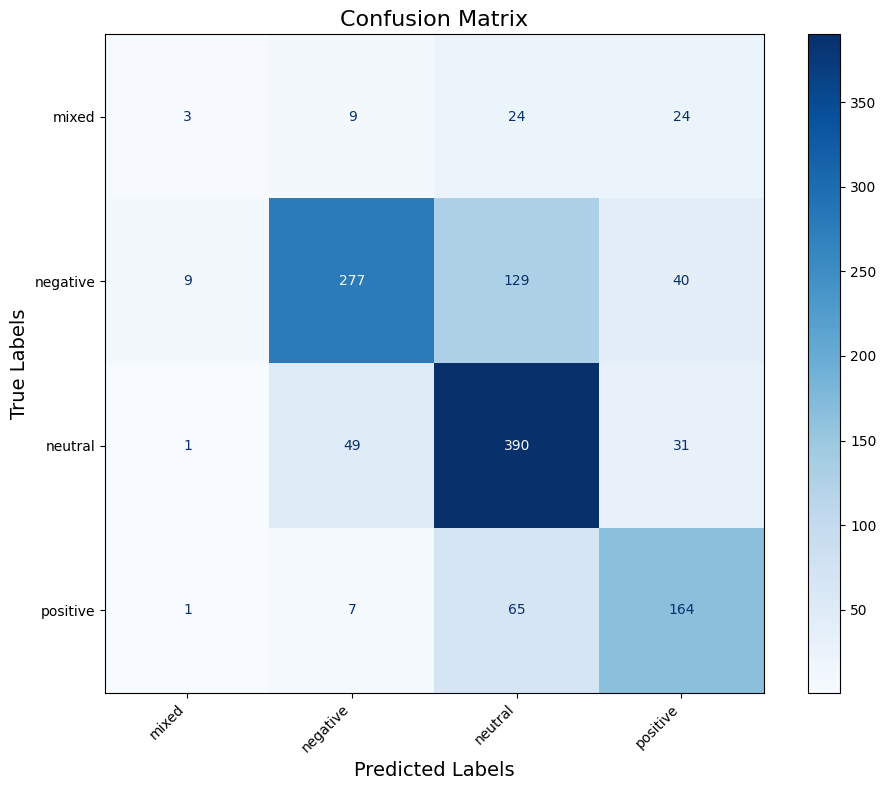

In [81]:
fig = visualize_confusion_matrix(df_clean)
plt.show()

Добре працює у: 

- визначенні нейтрального класу

- негатив часто плутаємо із нейтральним і позитивним іноді

- цікаво розглянути випадки помилок, коли негативний сплутано із позитивним



Гірше працюємо в: 

- позитивний у негативний дууууже рідко плутанина (подивись на випадки)

- Міксованого класу дуже мало. Модель не вчиться його визначати і майже зайжди вважає його або позитивним, або негативним

- Мікс клас виглядає як найбільша проблема, що логічно

- Вилікуватись очікувано має за допомогою аугментацій))))

Classification Report:
              precision    recall  f1-score   support

       mixed       0.29      0.23      0.26        60
    negative       0.71      0.74      0.73       455
     neutral       0.64      0.73      0.68       471
    positive       0.81      0.56      0.66       237

    accuracy                           0.68      1223
   macro avg       0.61      0.57      0.58      1223
weighted avg       0.68      0.68      0.68      1223



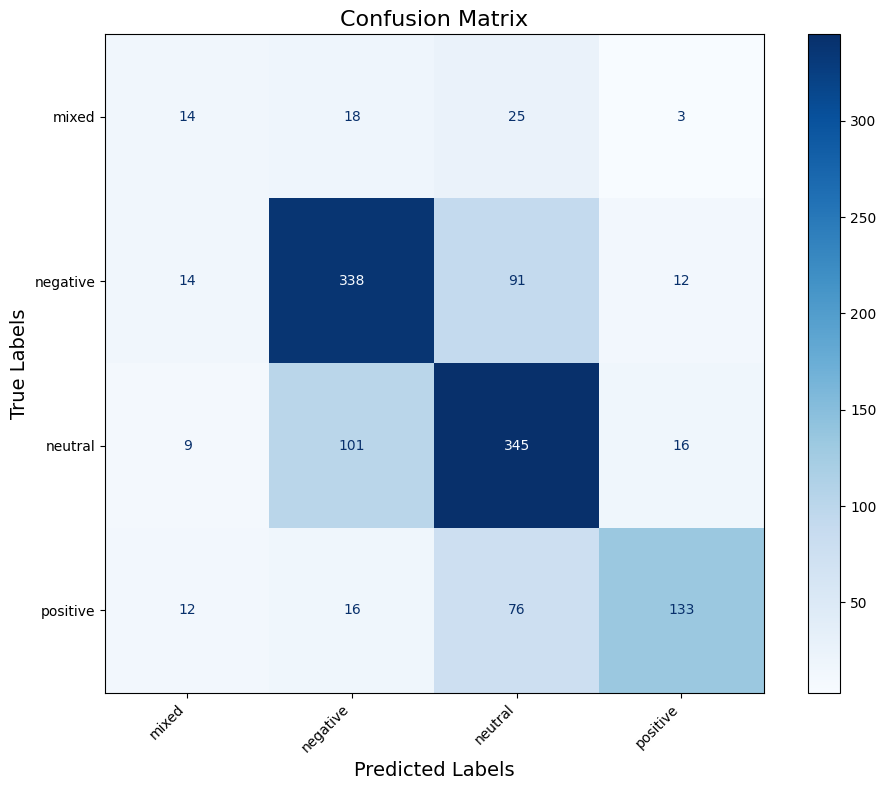

In [47]:
fig = visualize_confusion_matrix(df_clean)
plt.show()

In [92]:
df_clean.language.unique()

array(['ru', 'mixed', 'ua'], dtype=object)

Classification Report:
              precision    recall  f1-score   support

       mixed       0.43      0.75      0.55         4
    negative       0.82      0.87      0.84        31
     neutral       0.63      0.57      0.60        21
    positive       1.00      0.57      0.73         7

    accuracy                           0.73        63
   macro avg       0.72      0.69      0.68        63
weighted avg       0.75      0.73      0.73        63



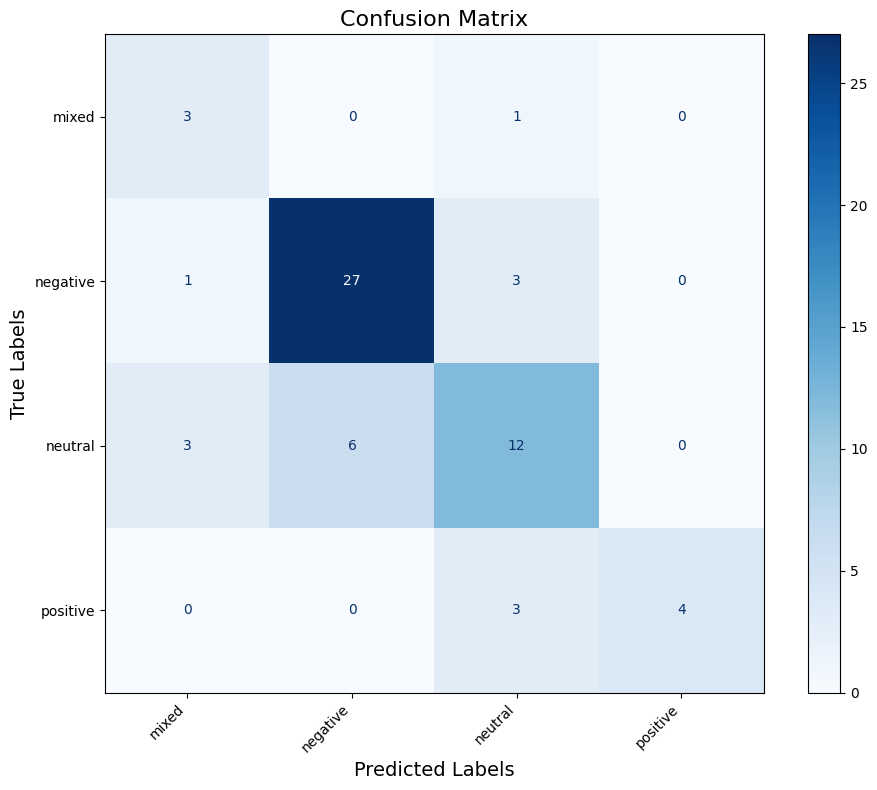

In [94]:
fig = visualize_confusion_matrix(df_clean.loc[df_clean.language == 'mixed'])
plt.show()

Classification Report:
              precision    recall  f1-score   support

       mixed       0.16      0.25      0.19        12
    negative       0.73      0.72      0.72       180
     neutral       0.60      0.58      0.59       121
    positive       0.64      0.61      0.63        44

    accuracy                           0.64       357
   macro avg       0.53      0.54      0.53       357
weighted avg       0.65      0.64      0.65       357



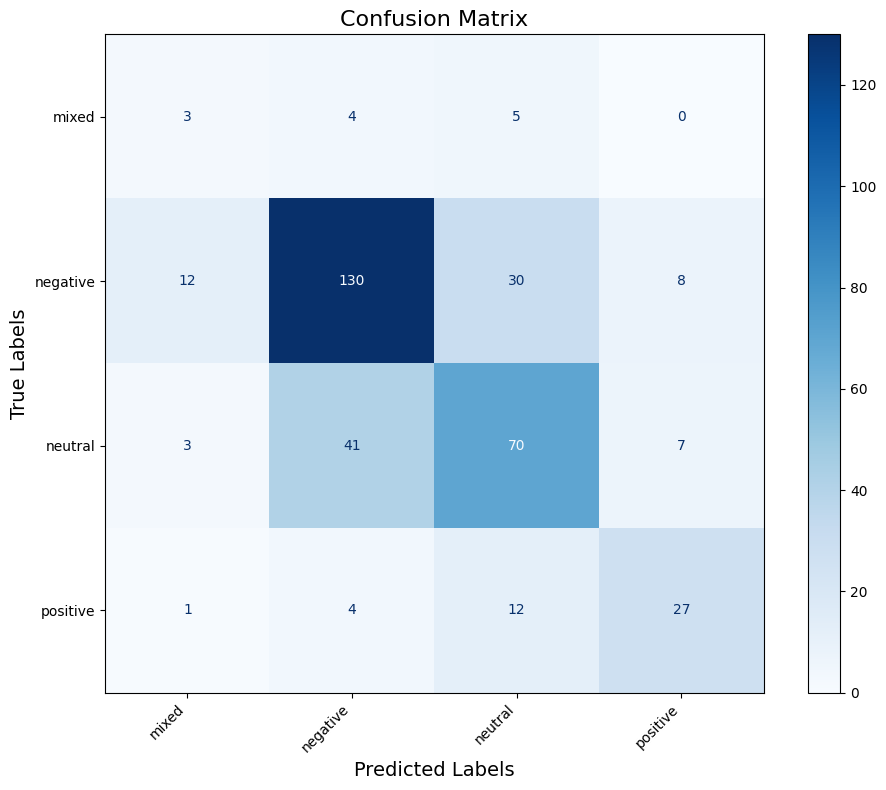

In [93]:
fig = visualize_confusion_matrix(df_clean.loc[df_clean.language == 'ru'])
plt.show()

Classification Report:
              precision    recall  f1-score   support

       mixed       0.35      0.18      0.24        44
    negative       0.69      0.74      0.72       244
     neutral       0.66      0.80      0.72       329
    positive       0.86      0.55      0.67       186

    accuracy                           0.69       803
   macro avg       0.64      0.57      0.59       803
weighted avg       0.70      0.69      0.68       803



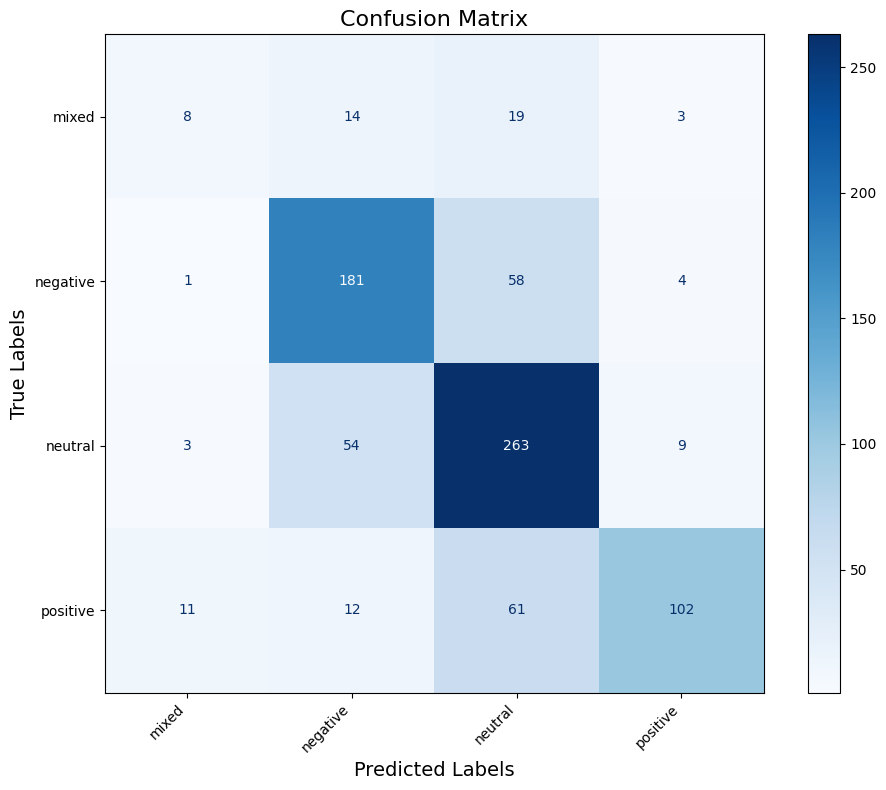

In [95]:
fig = visualize_confusion_matrix(df_clean.loc[df_clean.language == 'ua'])
plt.show()

## mBERT

In [81]:
report_bert, y_true_col_bert, y_pred_col_bert, all_indeces_bert, all_probs_bert = evaluate_model(model_bert, test_loader, batch_size=16)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:
print(report_bert)

              precision    recall  f1-score   support

       mixed     0.0000    0.0000    0.0000        60
    negative     0.3772    0.8637    0.5251       455
     neutral     0.4194    0.1104    0.1748       471
    positive     0.3158    0.0759    0.1224       237

    accuracy                         0.3786      1223
   macro avg     0.2781    0.2625    0.2056      1223
weighted avg     0.3630    0.3786    0.2864      1223



In [83]:
df_clean_2 = pd.DataFrame({'y_true_col': y_true_col_bert,
                         'y_pred_col': y_pred_col_bert,
                         'df_ids': all_indeces_bert})

In [84]:
df_clean_2 = df_clean_2.merge(df, how='left', left_on='df_ids', right_on='index')

In [85]:
df_clean_2.columns

Index(['y_true_col', 'y_pred_col', 'df_ids', 'index', 'response_id',
       'document_id', 'user_id', 'annotator_sentiment', 'is_ck_annotation',
       'response_timestamp', 'document_content', 'annotation_date', 'username',
       'unique_document_id', 'language_wc', 'document_length', 'gpt_labels_v1',
       'language_gpt', 'language_manual', 'language', 'stratification_label',
       'df_set'],
      dtype='object')

In [86]:
metrics_3 = evaluate_sentiment(df_clean_2, y_true_col="y_true_col", y_pred_col="y_pred_col", group_col="language")

In [87]:
pprint.pprint(metrics_3)

{'by_group': {'mixed': {'macro': {'f1': 0.16489361702127658,
                                  'precision': 0.12301587301587301,
                                  'recall': 0.25},
                        'micro': {'f1': 0.49206349206349204,
                                  'precision': 0.49206349206349204,
                                  'recall': 0.49206349206349204}},
              'ru': {'macro': {'f1': 0.2864109845354349,
                               'precision': 0.3500528144423493,
                               'recall': 0.3034779614325069},
                     'micro': {'f1': 0.5182072829131653,
                               'precision': 0.5182072829131653,
                               'recall': 0.5182072829131653}},
              'ua': {'macro': {'f1': 0.1731786249901334,
                               'precision': 0.2433453745069167,
                               'recall': 0.24726852975514044},
                     'micro': {'f1': 0.30759651307596514,
               

In [89]:
df_clean_2['models_sentiment'] = df_clean_2['y_pred_col'].apply(lambda x: {0: 'mixed', 1: 'negative', 2: 'neutral', 3:'positive'}[x])

Classification Report:
              precision    recall  f1-score   support

       mixed       0.00      0.00      0.00        60
    negative       0.38      0.86      0.53       455
     neutral       0.42      0.11      0.17       471
    positive       0.32      0.08      0.12       237

    accuracy                           0.38      1223
   macro avg       0.28      0.26      0.21      1223
weighted avg       0.36      0.38      0.29      1223



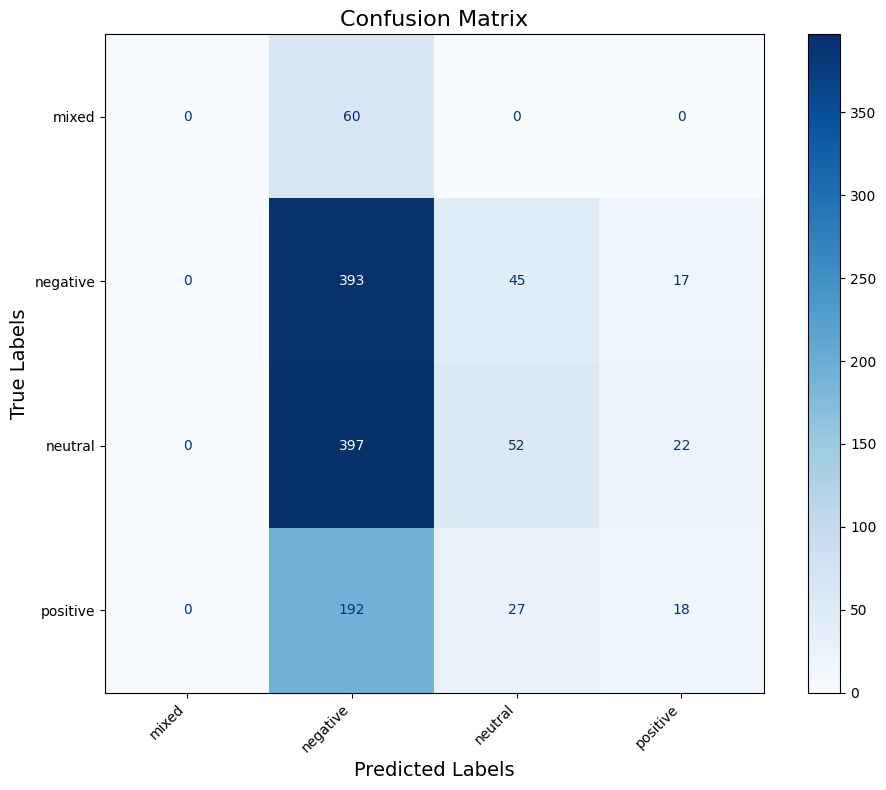

In [90]:
fig = visualize_confusion_matrix(df_clean_2)
plt.show()

Classification Report:
              precision    recall  f1-score   support

       mixed       0.00      0.00      0.00         4
    negative       0.49      1.00      0.66        31
     neutral       0.00      0.00      0.00        21
    positive       0.00      0.00      0.00         7

    accuracy                           0.49        63
   macro avg       0.12      0.25      0.16        63
weighted avg       0.24      0.49      0.32        63



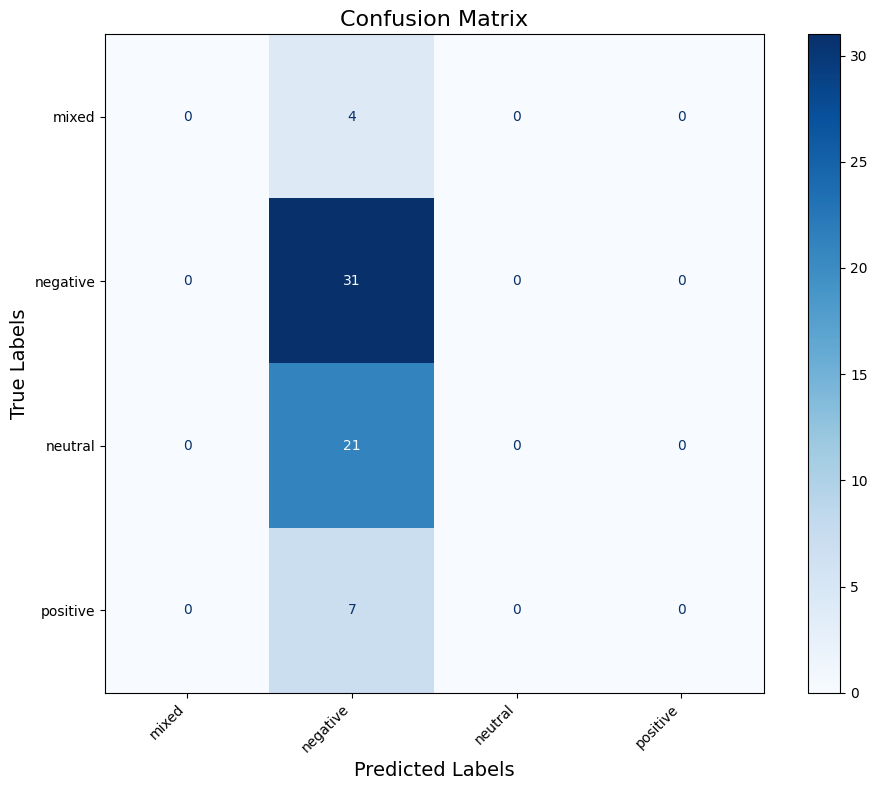

In [100]:
fig = visualize_confusion_matrix(df_clean_2.loc[df_clean_2.language == 'mixed'])
plt.show()

Classification Report:
              precision    recall  f1-score   support

       mixed       0.00      0.00      0.00        12
    negative       0.54      0.88      0.67       180
     neutral       0.42      0.15      0.22       121
    positive       0.44      0.18      0.26        44

    accuracy                           0.52       357
   macro avg       0.35      0.30      0.29       357
weighted avg       0.47      0.52      0.44       357



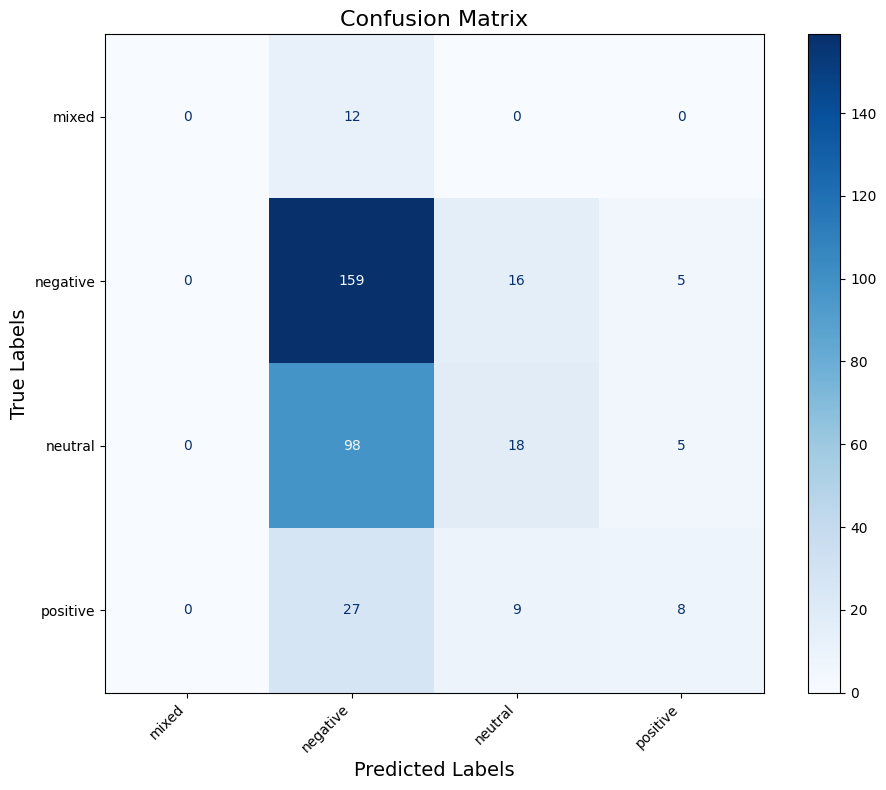

In [99]:
fig = visualize_confusion_matrix(df_clean_2.loc[df_clean_2.language == 'ru'])
plt.show()

Classification Report:
              precision    recall  f1-score   support

       mixed       0.00      0.00      0.00        44
    negative       0.30      0.83      0.44       244
     neutral       0.42      0.10      0.17       329
    positive       0.26      0.05      0.09       186

    accuracy                           0.31       803
   macro avg       0.24      0.25      0.17       803
weighted avg       0.32      0.31      0.22       803



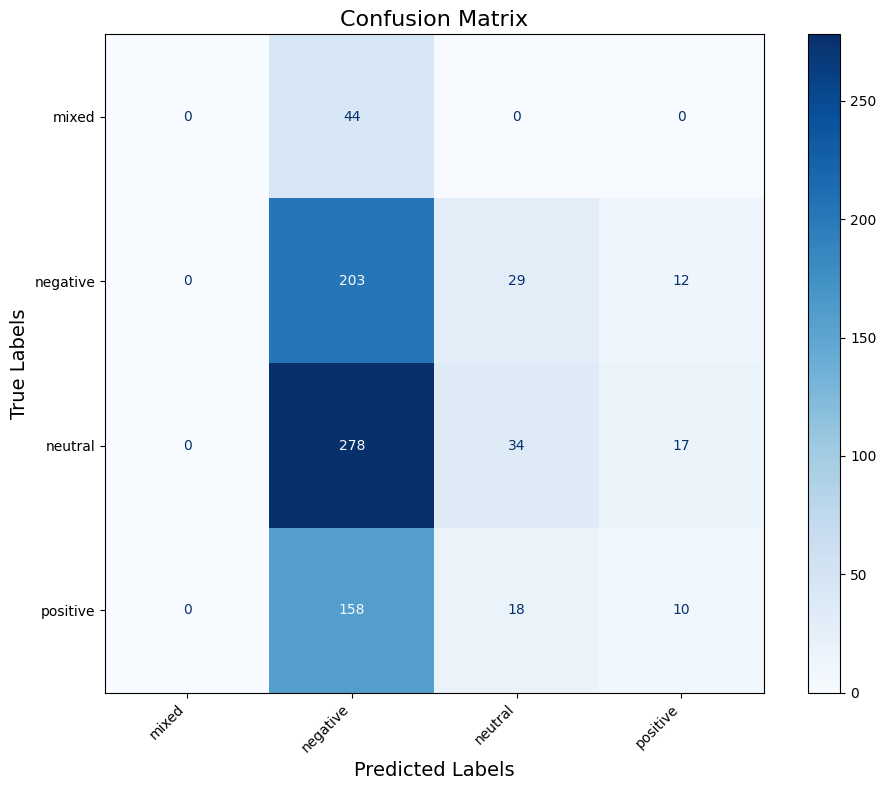

In [98]:
fig = visualize_confusion_matrix(df_clean_2.loc[df_clean_2.language == 'ua'])
plt.show()

# Expected calibration error

In [32]:
def _reliability_curve(labels, probs, model_name: str, ece: float, n_bins: int, ax, min_x: float = 0.4):
    """
    Add one reliability curve to an existing matplotlib Axes.
    Treats the max‑probability (top‑1) prediction as the model’s confidence.
    """
    labels = np.asarray(labels)
    probs = np.asarray(probs)

    # Top‑1 confidence and correctness (1 = hit, 0 = miss)
    conf = probs.max(axis=1)
    correct = (probs.argmax(axis=1) == labels).astype(int)

    frac_pos, mean_pred = calibration_curve(
        correct, conf, n_bins=n_bins, strategy="uniform"
    )
    
    # ------- keep only bins to the right of min_x -------
    keep = mean_pred >= min_x
    frac_pos  = frac_pos[keep]
    mean_pred = mean_pred[keep]
    # ----------------------------------------------------

    model_name=f"{model_name} (ECE={ece:.3f})"
    
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
    ax.plot(mean_pred, frac_pos, marker="o", label=model_name)
    return ax


def plot_calibration_diagrams(
    labels_roberta,
    probs_roberta,
    labels_mbert,
    probs_mbert,
    ece_roberta, 
    ece_bert,
    n_bins: int = 10,
    figsize=(6, 6),
):
    """
    Draw a side‑by‑side reliability diagram for UkrRoberta and mBERT.
    """
    fig, ax = plt.subplots(figsize=figsize)

    _reliability_curve(labels_roberta, probs_roberta, "UkrRoberta", ece_roberta, n_bins, ax)
    _reliability_curve(labels_mbert, probs_mbert, "mBERT", ece_bert, n_bins, ax)

    # ax.set_title("Reliability diagram (top‑1 confidence)")
    ax.set_xlabel("Predicted confidence")
    ax.set_ylabel("Empirical accuracy")
    ax.legend()
    plt.tight_layout()
    plt.savefig('reliability_diagram.png')
    plt.show()

In [33]:
rep_r, y_true_r, _, _, probs_r = evaluate_model(model, test_loader)
rep_b, y_true_b, _, _, probs_b = evaluate_model(model_bert, test_loader)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


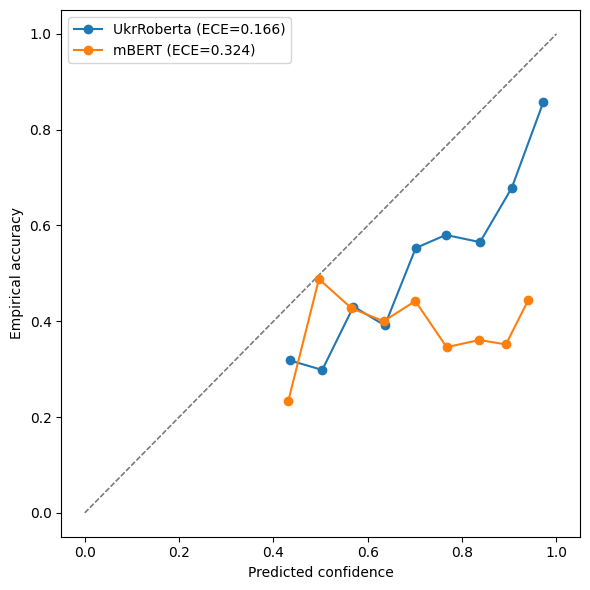

In [34]:
plot_calibration_diagrams(
    labels_roberta=y_true_r,
    probs_roberta=probs_r,
    labels_mbert=y_true_b,
    probs_mbert=probs_b,
    ece_roberta=0.1655,
    ece_bert=0.3243,
    n_bins=15,            # feel free to change
)

### By languages

### Overall

In [35]:
rep_r, y_true_r, _, _, probs_r = evaluate_model(model, test_loader)
rep_b, y_true_b, _, _, probs_b = evaluate_model(model_bert, test_loader)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
# ──────────────────────────────────────────────────────────────────────────────
def _reliability_bars(
        labels,
        probs,
        model_name: str,
        ece: float,
        n_bins: int,
        ax,
        bar_offset: float = 0.0,
        min_x: float = 0.4,
):
    """
    Plot one model’s reliability curve as bars.
    """
    labels = np.asarray(labels)
    probs  = np.asarray(probs)

    # top‑1 confidence and correctness (1 = hit, 0 = miss)
    conf    = probs.max(axis=1)
    correct = (probs.argmax(axis=1) == labels).astype(int)

    frac_pos, mean_pred = calibration_curve(
        correct, conf, n_bins=n_bins, strategy="uniform"
    )

    keep      = mean_pred >= min_x
    frac_pos  = frac_pos[keep]
    mean_pred = mean_pred[keep]

    bar_width = 1 / n_bins * 0.6                     # 60 % of bin width
    x = mean_pred + bar_offset                       # nudge bars left / right

    label = f"{model_name} (ECE={ece:.2f})"
    ax.bar(x, frac_pos, width=bar_width, label=label, alpha=0.7, edgecolor="black")


# ──────────────────────────────────────────────────────────────────────────────
def plot_calibration_diagrams(
        labels_roberta,
        probs_roberta,
        labels_mbert,
        probs_mbert,
        ece_roberta,
        ece_bert,
        png_path,
        n_bins: int = 10,
        figsize=(5, 4),
):
    """
    Side‑by‑side reliability diagram for UkrRoberta and mBERT.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Ideal calibration reference
    ax.plot([0, 1], [0, 1], linestyle="--",
            color="gray", linewidth=1, label="Calibration line")

    # Offsets so the two bar groups don’t overlap
    offset = 0.5 / n_bins * 0.6
    _reliability_bars(labels_roberta, probs_roberta, "UkrRoberta",
                      ece_roberta, n_bins, ax, bar_offset=-offset, min_x=0.5)
    _reliability_bars(labels_mbert,   probs_mbert,   "mBERT",
                      ece_bert,       n_bins, ax, bar_offset=+offset, min_x=0.5)

    ax.set_xlabel("Predicted confidence", fontsize=10)
    ax.set_ylabel("Empirical accuracy", fontsize=10)
    ax.tick_params(labelsize=10)

    ax.set_xlim(0.5, 1) 
    ax.set_ylim(0, 1)
    legend = ax.legend(fontsize=10) 
    plt.tight_layout()
    plt.savefig(png_path)
    plt.show()


    

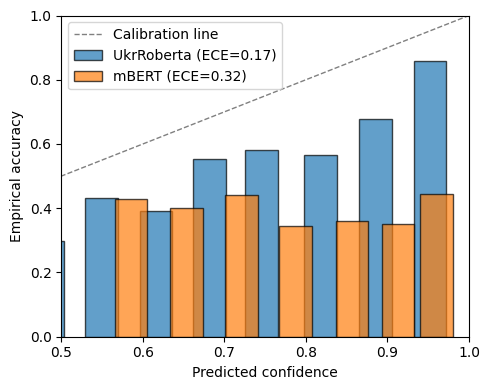

In [46]:
plot_calibration_diagrams(
    labels_roberta=y_true_r,
    probs_roberta=probs_r,
    labels_mbert=y_true_b,
    probs_mbert=probs_b,
    ece_roberta=0.17,
    ece_bert=0.32,
    png_path='overall_calibration_plot.png',
    n_bins=15,            # feel free to change
)

ece_roberta=0.1655,

ece_bert=0.3243,

### RU

In [47]:
rep_r, y_true_r, _, _, probs_r = evaluate_model(model, test_loader_ru)
rep_b, y_true_b, _, _, probs_b = evaluate_model(model_bert, test_loader_ru)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


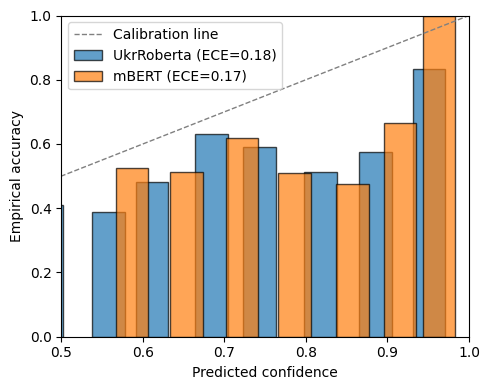

In [48]:
plot_calibration_diagrams(
    labels_roberta=y_true_r,
    probs_roberta=probs_r,
    labels_mbert=y_true_b,
    probs_mbert=probs_b,
    ece_roberta=0.18,
    ece_bert=0.17,
    png_path='ru_calibration_plot.png',
    n_bins=15,            # feel free to change
)

UkrRoberta ECE: 0.1790812539787186

mBERT ECE: 0.16651570763574594

### UA

In [49]:
rep_r, y_true_r, _, _, probs_r = evaluate_model(model, test_loader_ua)
rep_b, y_true_b, _, _, probs_b = evaluate_model(model_bert, test_loader_ua)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


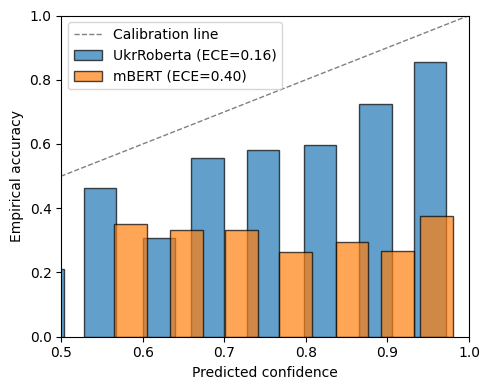

In [50]:
plot_calibration_diagrams(
    labels_roberta=y_true_r,
    probs_roberta=probs_r,
    labels_mbert=y_true_b,
    probs_mbert=probs_b,
    ece_roberta=0.16,
    ece_bert=0.40,
    png_path='ua_calibration_plot.png',
    n_bins=15,            # feel free to change
)

UkrRoberta ECE: 0.16264413543982642

mBERT ECE: 0.3995962035685666

### MIXED

In [51]:
rep_r, y_true_r, _, _, probs_r = evaluate_model(model, test_loader_mixed)
rep_b, y_true_b, _, _, probs_b = evaluate_model(model_bert, test_loader_mixed)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


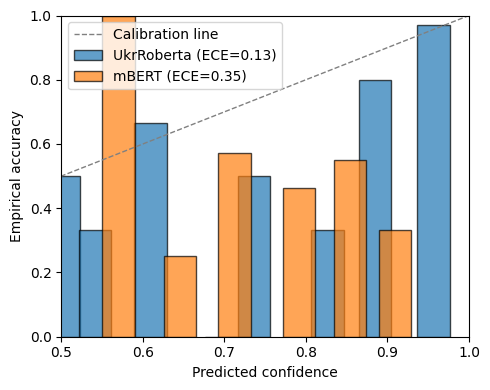

In [52]:
plot_calibration_diagrams(
    labels_roberta=y_true_r,
    probs_roberta=probs_r,
    labels_mbert=y_true_b,
    probs_mbert=probs_b,
    ece_roberta=0.13,
    ece_bert=0.35,
    png_path='mixed_calibration_plot.png',
    n_bins=15,            # feel free to change
)

UkrRoberta ECE: 0.12604201076522709

mBERT ECE: 0.35396601472582134

In [ ]:
def _reliability_bars(labels, probs, model_name, ece, n_bins, ax,
                      bar_width   = 0.08,          # overlaps a bit so colours mix nicely
                      min_x       = 0.0):          # we never drop bins here – we slice later
    labels = np.asarray(labels)
    probs  = np.asarray(probs)

    conf    = probs.max(axis=1)
    correct = (probs.argmax(axis=1) == labels).astype(int)

    frac_pos, mean_pred = calibration_curve(
        correct, conf, n_bins=n_bins, strategy="uniform"
    )

    # draw perfect‑calibration diagonal *once* per axis and capture handle
    calib_line, = ax.plot([0, 1], [0, 1],
                          linestyle="--", linewidth=1, color="gray",
                          label="Calibration line")

    # bar plot – shift the centres a hair so bars for both models are visible
    offset = (-1 if "Ukr" in model_name else 1) * bar_width / 2
    bars = ax.bar(mean_pred+offset,
                  frac_pos,
                  width=bar_width,
                  alpha=.75,
                  label=f"{model_name} (ECE={ece:.3f})")

    return calib_line, bars



def plot_calibration_panels(
        labels_roberta, probs_roberta,            # arrays
        labels_mbert,   probs_mbert,              # arrays
        languages_all,                            # same length, values in {'ua','ru','mixed'}
        ece_roberta, ece_mbert,
        n_bins      = 10,
        figsize     = (12, 12)
):
    """
    Draws four side‑by‑side reliability diagrams:

        (1) All data
        (2) Ukrainian‑only
        (3) Russian‑only
        (4) Code‑switched (mixed)
    """
    # assure NumPy arrays for easy boolean masking
    languages_all = np.asarray(languages_all)

    # figure‑level set‑up
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey=True)
    axes      = axes.ravel()      # flat iterator makes looping simpler

    # panel descriptors – (title, mask)
    panels = [
        ("All languages",        np.ones_like(languages_all, dtype=bool)),
        ("Ukrainian (ua)",       languages_all == "ua"),
        ("Russian (ru)",         languages_all == "ru"),
        ("Code‑switched (mixed)",languages_all == "mixed"),
    ]

    # draw every panel
    for ax, (title, mask) in zip(axes, panels):
        _reliability_bars(labels_roberta[mask], probs_roberta[mask],
                          "UkrRoberta", ece_roberta, n_bins, ax)
        calib_line, _ = _reliability_bars(labels_mbert[mask], probs_mbert[mask],
                                          "mBERT",       ece_mbert,   n_bins, ax)

        ax.set_title(title)
        ax.set_xlabel("Predicted confidence")
        ax.set_ylabel("Empirical accuracy")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # Only the first axis gets the legend (others share it automatically)
        ax.legend(loc="lower right")

    fig.suptitle("Reliability Diagrams – Overall and by Language", fontsize=15)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig("reliability_panels.png")
    plt.show()

In [ ]:
plot_calibration_diagrams(
    labels_roberta=y_true_r,
    probs_roberta=probs_r,
    labels_mbert=y_true_b,
    probs_mbert=probs_b,
    ece_roberta=0.1655,
    ece_bert=0.3243,
    n_bins=15,            # feel free to change
)

In [52]:
def plot_single_reliability_diagram(probs, labels, n_bins=10):
    """
    Plot reliability diagram to visualize calibration.
    
    Args:
        probs: Predicted probabilities of shape [n_samples, n_classes]
        labels: Ground truth labels of shape [n_samples]
        n_bins: Number of bins for confidence scores
    """
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == labels)
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(confidences, bin_boundaries, right=True) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_accuracies = np.zeros(n_bins)
    bin_confidences = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    for i in range(len(confidences)):
        bin_idx = bin_indices[i]
        bin_accuracies[bin_idx] += accuracies[i]
        bin_confidences[bin_idx] += confidences[i]
        bin_counts[bin_idx] += 1
    
    for i in range(n_bins):
        if bin_counts[i] > 0:
            bin_accuracies[i] /= bin_counts[i]
            bin_confidences[i] /= bin_counts[i]
    
    # Calculate ECE
    ece = 0
    for i in range(n_bins):
        if bin_counts[i] > 0:
            ece += (bin_counts[i] / len(confidences)) * abs(bin_accuracies[i] - bin_confidences[i])
    
    # Plot
    plt.figure(figsize=(10, 8))
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    
    # Plot the bins with data
    valid_bins = bin_counts > 0
    plt.bar(bin_centers[valid_bins], bin_accuracies[valid_bins], width=1/n_bins, alpha=0.3, label='Accuracy')
    plt.plot(bin_centers[valid_bins], bin_confidences[valid_bins], 'ro-', label='Confidence')
    
    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title(f'Reliability Diagram (ECE: {ece:.4f})')
    plt.legend()
    plt.grid(True)
    plt.savefig('reliability_diagram.png')
    plt.show()
    
    return ece

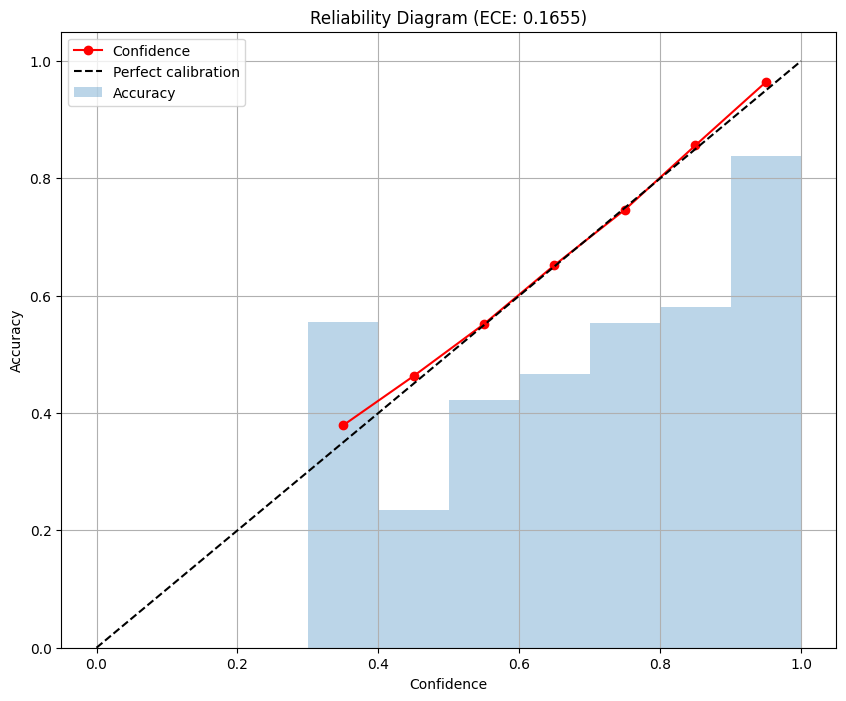

In [54]:
ece = plot_single_reliability_diagram(all_probs, y_true_col, n_bins=10)

## Inputs creation for the compaison

In [149]:
_, y_true_col_ukrroberta, y_pred_col_ukrroberta, all_indeces_ukrroberta, all_probs_ukrroberta = evaluate_model(model, 
                                                                                                               test_loader, 
                                                                                                               batch_size=16)

In [150]:
_, y_true_col_bert, y_pred_col_bert, all_indeces_bert, all_probs_bert = evaluate_model(model_bert, 
                                                                                       test_loader, 
                                                                                       batch_size=16)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [151]:
len(y_true_col_bert)

1223

In [152]:
def compute_calibration_info(probs, labels, n_bins=10):
    """
    Compute calibration information for a model
    
    Args:
        probs: Predicted probabilities of shape [n_samples, n_classes]
        labels: Ground truth labels of shape [n_samples]
        n_bins: Number of bins for confidence scores
        
    Returns:
        Dictionary containing calibration information
    """
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == labels)
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(confidences, bin_boundaries, right=True) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_accuracies = np.zeros(n_bins)
    bin_confidences = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    for i in range(len(confidences)):
        bin_idx = bin_indices[i]
        bin_accuracies[bin_idx] += accuracies[i]
        bin_confidences[bin_idx] += confidences[i]
        bin_counts[bin_idx] += 1
    
    for i in range(n_bins):
        if bin_counts[i] > 0:
            bin_accuracies[i] /= bin_counts[i]
            bin_confidences[i] /= bin_counts[i]
    
    # Calculate ECE
    ece = 0
    for i in range(n_bins):
        if bin_counts[i] > 0:
            ece += (bin_counts[i] / len(confidences)) * abs(bin_accuracies[i] - bin_confidences[i])
    
    return {
        'ece': ece,
        'bin_accuracies': bin_accuracies,
        'bin_confidences': bin_confidences,
        'bin_counts': bin_counts,
        'bin_boundaries': bin_boundaries,
        'accuracy': accuracy_score(predictions, labels)
    }

In [153]:
roberta_calibration = compute_calibration_info(all_probs_ukrroberta, y_true_col_ukrroberta, n_bins=10)

In [154]:
bert_calibration = compute_calibration_info(all_probs_bert, y_true_col_bert, n_bins=10)

In [155]:
model_data = {
    'UkrRoberta': roberta_calibration,
    'mBERT': bert_calibration
}


In [156]:
# Print detailed metrics
print("UkrRoberta ECE:", roberta_calibration['ece'])
print("mBERT ECE:", bert_calibration['ece'])
print("UkrRoberta Accuracy:", roberta_calibration['accuracy'])
print("mBERT Accuracy:", bert_calibration['accuracy'])

UkrRoberta ECE: 0.16548466994347188
mBERT ECE: 0.3243806803216724
UkrRoberta Accuracy: 0.678659035159444
mBERT Accuracy: 0.3785772690106296


### UA

In [157]:
_, y_true_col_ukrroberta, y_pred_col_ukrroberta, all_indeces_ukrroberta, all_probs_ukrroberta = evaluate_model(model, 
                                                                                                               test_loader_ua, 
                                                                                                               batch_size=16)

In [158]:
_, y_true_col_bert, y_pred_col_bert, all_indeces_bert, all_probs_bert = evaluate_model(model_bert, 
                                                                                       test_loader_ua, 
                                                                                       batch_size=16)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [159]:
len(y_true_col_bert)

803

In [160]:
def compute_calibration_info(probs, labels, n_bins=10):
    """
    Compute calibration information for a model
    
    Args:
        probs: Predicted probabilities of shape [n_samples, n_classes]
        labels: Ground truth labels of shape [n_samples]
        n_bins: Number of bins for confidence scores
        
    Returns:
        Dictionary containing calibration information
    """
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == labels)
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(confidences, bin_boundaries, right=True) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_accuracies = np.zeros(n_bins)
    bin_confidences = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    for i in range(len(confidences)):
        bin_idx = bin_indices[i]
        bin_accuracies[bin_idx] += accuracies[i]
        bin_confidences[bin_idx] += confidences[i]
        bin_counts[bin_idx] += 1
    
    for i in range(n_bins):
        if bin_counts[i] > 0:
            bin_accuracies[i] /= bin_counts[i]
            bin_confidences[i] /= bin_counts[i]
    
    # Calculate ECE
    ece = 0
    for i in range(n_bins):
        if bin_counts[i] > 0:
            ece += (bin_counts[i] / len(confidences)) * abs(bin_accuracies[i] - bin_confidences[i])
    
    return {
        'ece': ece,
        'bin_accuracies': bin_accuracies,
        'bin_confidences': bin_confidences,
        'bin_counts': bin_counts,
        'bin_boundaries': bin_boundaries,
        'accuracy': accuracy_score(predictions, labels)
    }

In [161]:
roberta_calibration = compute_calibration_info(all_probs_ukrroberta, y_true_col_ukrroberta, n_bins=10)

In [162]:
bert_calibration = compute_calibration_info(all_probs_bert, y_true_col_bert, n_bins=10)

In [163]:
model_data = {
    'UkrRoberta': roberta_calibration,
    'mBERT': bert_calibration
}


In [164]:
# Print detailed metrics
print("UkrRoberta ECE:", roberta_calibration['ece'])
print("mBERT ECE:", bert_calibration['ece'])
print("UkrRoberta Accuracy:", roberta_calibration['accuracy'])
print("mBERT Accuracy:", bert_calibration['accuracy'])

UkrRoberta ECE: 0.16264413543982642
mBERT ECE: 0.3995962035685666
UkrRoberta Accuracy: 0.6899128268991283
mBERT Accuracy: 0.30759651307596514


### RU

In [165]:
_, y_true_col_ukrroberta, y_pred_col_ukrroberta, all_indeces_ukrroberta, all_probs_ukrroberta = evaluate_model(model, 
                                                                                                               test_loader_ru, 
                                                                                                               batch_size=16)

In [166]:
_, y_true_col_bert, y_pred_col_bert, all_indeces_bert, all_probs_bert = evaluate_model(model_bert, 
                                                                                       test_loader_ru, 
                                                                                       batch_size=16)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [167]:
len(y_true_col_bert)

357

In [168]:
def compute_calibration_info(probs, labels, n_bins=10):
    """
    Compute calibration information for a model
    
    Args:
        probs: Predicted probabilities of shape [n_samples, n_classes]
        labels: Ground truth labels of shape [n_samples]
        n_bins: Number of bins for confidence scores
        
    Returns:
        Dictionary containing calibration information
    """
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == labels)
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(confidences, bin_boundaries, right=True) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_accuracies = np.zeros(n_bins)
    bin_confidences = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    for i in range(len(confidences)):
        bin_idx = bin_indices[i]
        bin_accuracies[bin_idx] += accuracies[i]
        bin_confidences[bin_idx] += confidences[i]
        bin_counts[bin_idx] += 1
    
    for i in range(n_bins):
        if bin_counts[i] > 0:
            bin_accuracies[i] /= bin_counts[i]
            bin_confidences[i] /= bin_counts[i]
    
    # Calculate ECE
    ece = 0
    for i in range(n_bins):
        if bin_counts[i] > 0:
            ece += (bin_counts[i] / len(confidences)) * abs(bin_accuracies[i] - bin_confidences[i])
    
    return {
        'ece': ece,
        'bin_accuracies': bin_accuracies,
        'bin_confidences': bin_confidences,
        'bin_counts': bin_counts,
        'bin_boundaries': bin_boundaries,
        'accuracy': accuracy_score(predictions, labels)
    }

In [169]:
roberta_calibration = compute_calibration_info(all_probs_ukrroberta, y_true_col_ukrroberta, n_bins=10)

In [170]:
bert_calibration = compute_calibration_info(all_probs_bert, y_true_col_bert, n_bins=10)

In [171]:
model_data = {
    'UkrRoberta': roberta_calibration,
    'mBERT': bert_calibration
}


In [172]:
# Print detailed metrics
print("UkrRoberta ECE:", roberta_calibration['ece'])
print("mBERT ECE:", bert_calibration['ece'])
print("UkrRoberta Accuracy:", roberta_calibration['accuracy'])
print("mBERT Accuracy:", bert_calibration['accuracy'])

UkrRoberta ECE: 0.1790812539787186
mBERT ECE: 0.16651570763574594
UkrRoberta Accuracy: 0.6442577030812325
mBERT Accuracy: 0.5182072829131653


### MIXED

In [173]:
_, y_true_col_ukrroberta, y_pred_col_ukrroberta, all_indeces_ukrroberta, all_probs_ukrroberta = evaluate_model(model, 
                                                                                                               test_loader_mixed, 
                                                                                                               batch_size=16)

In [174]:
_, y_true_col_bert, y_pred_col_bert, all_indeces_bert, all_probs_bert = evaluate_model(model_bert, 
                                                                                       test_loader_mixed, 
                                                                                       batch_size=16)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [175]:
len(y_true_col_bert)

63

In [176]:
def compute_calibration_info(probs, labels, n_bins=10):
    """
    Compute calibration information for a model
    
    Args:
        probs: Predicted probabilities of shape [n_samples, n_classes]
        labels: Ground truth labels of shape [n_samples]
        n_bins: Number of bins for confidence scores
        
    Returns:
        Dictionary containing calibration information
    """
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == labels)
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(confidences, bin_boundaries, right=True) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_accuracies = np.zeros(n_bins)
    bin_confidences = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    for i in range(len(confidences)):
        bin_idx = bin_indices[i]
        bin_accuracies[bin_idx] += accuracies[i]
        bin_confidences[bin_idx] += confidences[i]
        bin_counts[bin_idx] += 1
    
    for i in range(n_bins):
        if bin_counts[i] > 0:
            bin_accuracies[i] /= bin_counts[i]
            bin_confidences[i] /= bin_counts[i]
    
    # Calculate ECE
    ece = 0
    for i in range(n_bins):
        if bin_counts[i] > 0:
            ece += (bin_counts[i] / len(confidences)) * abs(bin_accuracies[i] - bin_confidences[i])
    
    return {
        'ece': ece,
        'bin_accuracies': bin_accuracies,
        'bin_confidences': bin_confidences,
        'bin_counts': bin_counts,
        'bin_boundaries': bin_boundaries,
        'accuracy': accuracy_score(predictions, labels)
    }

In [177]:
roberta_calibration = compute_calibration_info(all_probs_ukrroberta, y_true_col_ukrroberta, n_bins=10)

In [178]:
bert_calibration = compute_calibration_info(all_probs_bert, y_true_col_bert, n_bins=10)

In [179]:
model_data = {
    'UkrRoberta': roberta_calibration,
    'mBERT': bert_calibration
}


In [180]:
# Print detailed metrics
print("UkrRoberta ECE:", roberta_calibration['ece'])
print("mBERT ECE:", bert_calibration['ece'])
print("UkrRoberta Accuracy:", roberta_calibration['accuracy'])
print("mBERT Accuracy:", bert_calibration['accuracy'])

UkrRoberta ECE: 0.12604201076522709
mBERT ECE: 0.35396601472582134
UkrRoberta Accuracy: 0.7301587301587301
mBERT Accuracy: 0.49206349206349204
